In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os

import gc
import re
import operator 

import numpy as np
import pandas as pd
import cv2

from sklearn import model_selection
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from keras.preprocessing import image as Im

from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dense, Activation, Lambda, Reshape, Flatten
from keras.models import Model, load_model

from keras import backend as K
import argparse

from sklearn.model_selection import train_test_split, cross_val_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv2D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten, Masking
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,  Callback, EarlyStopping, ReduceLROnPlateau



Using TensorFlow backend.


In [3]:
TRAIN_PATH='./selector_output/train'
TEST_PATH='./selector_output/val'
UNLABELLED_PATH="./selector_output/unlab"

In [75]:
#FOR VALIDATION DATA
gen = ImageDataGenerator()
data = gen.flow_from_directory(TRAIN_PATH, target_size=(128, 128), class_mode='binary', batch_size=128, shuffle=False)
data.reset()
images, classes = data.next()
img_ary = np.array(images.astype('float'))
cls_ary = np.array(classes)
rng = int(data.samples // 128)

for _ in range(rng):
    
    images, classes = data.next()
    img_ary = np.vstack((img_ary, images.astype('float')))
    cls_ary = np.hstack((cls_ary, classes))
    print (_)

#channel_means = img_ary.mean(axis=(0,1,2)).astype('float')
#img_ary = img_ary - channel_means
    
train_X = img_ary
#train_X=train_X/train_X.max()
train_y = cls_ary

Found 120 images belonging to 2 classes.


In [76]:
#FOR VALIDATION DATA
gen = ImageDataGenerator()
data = gen.flow_from_directory(TEST_PATH, target_size=(128, 128), class_mode='binary', batch_size=128, shuffle=False)
data.reset()
images, classes = data.next()
img_ary = np.array(images.astype('float'))
cls_ary = np.array(classes)
rng = int(data.samples // 128)

for _ in range(rng):
    
    images, classes = data.next()
    img_ary = np.vstack((img_ary, images.astype('float')))
    cls_ary = np.hstack((cls_ary, classes))
    print (_)

#channel_means = img_ary.mean(axis=(0,1,2)).astype('float')
#img_ary = img_ary - channel_means
    
train_X_val = img_ary
#train_X_val=train_X_val/train_X_val.max()
train_y_val = cls_ary

Found 1787 images belonging to 2 classes.
0
1
2
3
4
5
6
7
8
9
10
11
12


In [10]:
train_X_val.max()

1.0

In [7]:
data.class_indices

{'person': 0, 'worker': 1}

In [77]:
#FOR VALIDATION DATA
gen = ImageDataGenerator()
data = gen.flow_from_directory(UNLABELLED_PATH, target_size=(128, 128), class_mode=None, batch_size=128, shuffle=False)
data.reset()
images = data.next()
img_ary = np.array(images.astype('float'))
rng = int(data.samples // 128)
print(1)
for _ in range(rng):
    
    images= data.next()
    img_ary = np.vstack((img_ary, images.astype('float')))
    
print(2)    

#channel_means = img_ary.mean(axis=(0,1,2)).astype('float')
#img_ary = img_ary - channel_means
    
train_X_unlab = img_ary
train_X_unlab=train_X_unlab/train_X_unlab.max()


Found 9852 images belonging to 1 classes.
1
2


In [12]:
train_y_unlab=[]
for name in data.filenames:
    if "\p" in name:
        train_y_unlab.append(0)
        
    else:
        train_y_unlab.append(1)
        

In [13]:
train_y_unlab=np.array(train_y_unlab)

In [14]:
train_y_unlab=train_y_unlab.reshape(-1)

In [15]:
train_y_unlab

array([0, 0, 0, ..., 1, 1, 1])

In [176]:
len(train_X_unlab)

9852

In [16]:
gen_normalize=ImageDataGenerator(featurewise_std_normalization=True)

D:\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:346: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [178]:
def transformation(data):
    gen_normalize.fit(data)
    train_iterator = gen_normalize.flow(data,batch_size=len(data))
    data=train_iterator.next()
    return data

In [17]:
#train_X train_y train_X_val train_y_val  train_X_unlab train_y_unlab
train_X_full=np.concatenate((train_X,train_X_unlab),axis=0)
train_y_full=np.concatenate((train_y,train_y_unlab),axis=0)

In [18]:
len(train_X_full)

9972

In [181]:
#train_X_full=transformation(train_X_full)

In [19]:
train_X_full

array([[[[ 0.4850262 ,  0.46697989,  0.48618089],
         [ 0.4850262 ,  0.46697989,  0.48618089],
         [ 0.4850262 ,  0.46697989,  0.48618089],
         ...,
         [ 0.45959539,  0.46697989,  0.40988847],
         [ 0.45959539,  0.46697989,  0.40988847],
         [ 0.45959539,  0.46697989,  0.40988847]],

        [[ 0.4850262 ,  0.46697989,  0.48618089],
         [ 0.4850262 ,  0.46697989,  0.48618089],
         [ 0.4850262 ,  0.46697989,  0.48618089],
         ...,
         [ 0.45959539,  0.46697989,  0.40988847],
         [ 0.45959539,  0.46697989,  0.40988847],
         [ 0.45959539,  0.46697989,  0.40988847]],

        [[ 0.45959539,  0.45426449,  0.46710778],
         [ 0.45959539,  0.45426449,  0.46710778],
         [ 0.45959539,  0.45426449,  0.46710778],
         ...,
         [ 0.36422987,  0.37161437,  0.31452295],
         [ 0.36422987,  0.37161437,  0.31452295],
         [ 0.36422987,  0.37161437,  0.31452295]],

        ...,

        [[ 0.34515677,  0.35254127,  0

In [183]:
#train_X_val=transformation(train_X_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


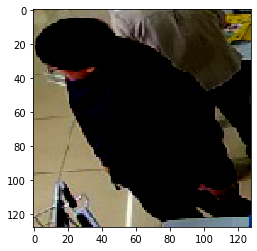

In [20]:
plt.imshow(train_X_val[0])

In [34]:
import warnings
warnings.filterwarnings("ignore")

from keras.applications.vgg16 import VGG16


In [35]:
mobile_net_base = VGG16(weights='imagenet', include_top=False, input_shape = (128,128,3))


In [36]:
mobile_net_base.layers

In [37]:
mobile_net_base.layers[:-2]

In [61]:
def model_design():
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape = (128,128,3))
    vgg16_base.layers
    for layer in vgg16_base.layers[:-2]:
        layer.trainable=False
    x=vgg16_base.output
    x=Dropout(0.10)(x)
    x= Flatten()(x)
    x=Dropout(0.20)(x)
    x=Dense(512,activation='relu')(x)
    x=Dropout(0.30)(x)
    
    x=Dense(2,activation='softmax')(x)
  
    return x,vgg16_base.input


In [41]:
x,inps=model_design()

In [42]:
model=Model(inputs=inps,outputs=x)

In [43]:
model.compile(Adam(lr=1e-6), loss='binary_crossentropy', metrics=['accuracy'])


In [44]:
from sklearn.model_selection import train_test_split, StratifiedKFold


In [27]:

folds = []
k = 3
def load_data_kfold(k, train_X, train_y1):
    print("Enter Load_data_kfold")
    global folds
    folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(train_X, train_y1))
    print("Exit Load_data_kfold")
    return folds
    

In [28]:
load_data_kfold(10,train_X_full,train_y_full) 

Enter Load_data_kfold
Exit Load_data_kfold


[(array([   0,    1,    2, ..., 9968, 9969, 9970]),
  array([   5,   11,   12,   19,   21,   37,   57,   73,   78,   80,   92,
           98,  102,  103,  107,  112,  122,  139,  158,  168,  186,  221,
          225,  229,  241,  252,  260,  263,  266,  279,  282,  304,  308,
          335,  336,  340,  345,  359,  374,  382,  385,  408,  409,  419,
          432,  454,  488,  500,  507,  517,  561,  563,  576,  577,  604,
          612,  615,  616,  626,  634,  652,  660,  668,  670,  683,  696,
          704,  705,  738,  744,  747,  778,  784,  789,  819,  821,  831,
          839,  843,  855,  856,  859,  864,  896,  899,  914,  918,  923,
          930,  931,  934,  941,  951,  955,  959,  961,  966,  970,  991,
         1001, 1018, 1047, 1056, 1071, 1090, 1094, 1098, 1101, 1102, 1104,
         1111, 1120, 1141, 1154, 1181, 1186, 1200, 1201, 1215, 1220, 1225,
         1229, 1245, 1295, 1296, 1302, 1306, 1307, 1316, 1331, 1337, 1357,
         1412, 1415, 1437, 1440, 1441, 1446, 144

In [29]:
es=EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min', baseline=None, restore_best_weights=True)

In [30]:
train_X_full.min()

-0.6772784509994744

In [31]:
train_X_val.max()

1.0

In [32]:
train_X_full[5]

array([[[ 0.65032643,  0.63863782,  0.47346548],
        [ 0.65668413,  0.65771093,  0.51796939],
        [ 0.65668413,  0.65771093,  0.51796939],
        ...,
        [ 0.4850262 ,  0.5051261 , -0.30853178],
        [ 0.4850262 ,  0.5051261 , -0.30853178],
        [ 0.40873378,  0.39704518, -0.39118189]],

       [[ 0.85377287,  0.83572656,  0.68962733],
        [ 0.85377287,  0.84844197,  0.72141583],
        [ 0.85377287,  0.84844197,  0.72141583],
        ...,
        [ 0.5231724 ,  0.54963001, -0.26402787],
        [ 0.5231724 ,  0.54963001, -0.26402787],
        [ 0.4850262 ,  0.47333759, -0.31488948]],

       [[ 0.73297655,  0.73400334,  0.59426181],
        [ 0.86013057,  0.85479967,  0.74048894],
        [ 0.86013057,  0.85479967,  0.74048894],
        ...,
        [ 0.54224551,  0.5369146 , -0.28945867],
        [ 0.54224551,  0.5369146 , -0.28945867],
        [ 0.47231079,  0.42247598, -0.37210879]],

       ...,

       [[-0.34147497, -0.22600955,  0.16193812],
        [-0

In [200]:
import warnings
warnings.filterwarnings("ignore")

In [45]:

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = False,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 10
                        )


for j, (train_idx, val_idx) in enumerate(folds):
    print('\nFold', j)
    #print(np.array(y_label)[train_idx])
    X_train_cv = train_X_full[train_idx]
    y_train_cv = train_y_full[train_idx]
    X_valid_cv = train_X_full[val_idx]
    y_valid_cv= train_y_full[val_idx]
    #gen.fit(X_train_cv)
    
#        name_weights = "final_model_fold" + str(j) + "_weights.h5"
#        callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = 128)
#        model = get_model()
    model.fit_generator(generator,
                        steps_per_epoch=len(X_train_cv)/50,
                        epochs=25,
                        shuffle=False,
                        verbose=1,
                        
                        validation_data = (train_X_val, train_y_val),
                        validation_steps=len(train_X_val),
                        callbacks=[es]         
                    )
    print(model.evaluate(train_X_val, train_y_val))


Fold 0
Epoch 1/25
180/179 [==============================] - 101s 564ms/step - loss: 0.7481 - acc: 0.5389 - val_loss: 0.6390 - val_acc: 0.6407
Epoch 2/25
180/179 [==============================] - 59s 328ms/step - loss: 0.6657 - acc: 0.6131 - val_loss: 0.6014 - val_acc: 0.7045
Epoch 3/25
180/179 [==============================] - 61s 339ms/step - loss: 0.6051 - acc: 0.6703 - val_loss: 0.5673 - val_acc: 0.7314
Epoch 4/25
180/179 [==============================] - 61s 340ms/step - loss: 0.5586 - acc: 0.7087 - val_loss: 0.5387 - val_acc: 0.7549
Epoch 5/25
180/179 [==============================] - 62s 346ms/step - loss: 0.5194 - acc: 0.7409 - val_loss: 0.5103 - val_acc: 0.7762
Epoch 6/25
180/179 [==============================] - 62s 345ms/step - loss: 0.4855 - acc: 0.7673 - val_loss: 0.4861 - val_acc: 0.7929
Epoch 7/25
180/179 [==============================] - 62s 346ms/step - loss: 0.4563 - acc: 0.7868 - val_loss: 0.4631 - val_acc: 0.8064
Epoch 8/25
180/179 [==========================

KeyboardInterrupt: 

In [ ]:
model.save("model_mobile_net_layer_train_false.h5")


# Starting with k fold for PL 

In [78]:
#starting with k fold on 100 images and validation for pseudo labelling
x_1,inps_1=model_design()
model_k_fold=Model(inputs=inps_1,outputs=x_1)
model_k_fold.compile(Adam(lr=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])


In [79]:
from keras.utils import to_categorical
from keras.applications.vgg16 import preprocess_input


In [81]:
train_X = preprocess_input(train_X)
train_X_val= preprocess_input(train_X_val)

In [82]:
load_data_kfold(3,train_X,train_y) 

Enter Load_data_kfold
Exit Load_data_kfold


[(array([  0,   1,   4,   5,   6,   7,   8,   9,  11,  12,  13,  14,  15,
          16,  17,  18,  20,  22,  23,  25,  28,  29,  30,  31,  32,  34,
          37,  38,  42,  43,  45,  47,  49,  51,  54,  55,  56,  57,  58,
          59,  60,  61,  63,  64,  67,  68,  69,  70,  73,  74,  75,  76,
          77,  78,  79,  82,  83,  85,  86,  87,  91,  92,  93,  94,  96,
          98,  99, 100, 101, 104, 105, 107, 108, 109, 110, 111, 113, 114,
         117, 118]),
  array([  2,   3,  10,  19,  21,  24,  26,  27,  33,  35,  36,  39,  40,
          41,  44,  46,  48,  50,  52,  53,  62,  65,  66,  71,  72,  80,
          81,  84,  88,  89,  90,  95,  97, 102, 103, 106, 112, 115, 116,
         119])),
 (array([  0,   1,   2,   3,   5,   6,   7,   8,   9,  10,  11,  12,  15,
          16,  18,  19,  20,  21,  24,  25,  26,  27,  33,  35,  36,  37,
          39,  40,  41,  43,  44,  45,  46,  48,  50,  52,  53,  57,  58,
          59,  60,  62,  63,  64,  65,  66,  67,  69,  71,  72,  75,  76,


In [86]:
train_X_val.max()

151.061

In [87]:
train_y = to_categorical(train_y, 2)
train_y_val =to_categorical(train_y_val, 2)

In [88]:

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = False,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 10
                        )


for j, (train_idx, val_idx) in enumerate(folds):
    print('\nFold', j)
    #print(np.array(y_label)[train_idx])
    X_train_cv = train_X[train_idx]
    y_train_cv = train_y[train_idx]
    X_valid_cv = train_X[val_idx]
    y_valid_cv= train_y[val_idx]
    #gen.fit(X_train_cv)
    
#        name_weights = "final_model_fold" + str(j) + "_weights.h5"
#        callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = 128)
#        model = get_model()
    model_k_fold.fit_generator(generator,
                        steps_per_epoch=len(train_X),
                        epochs=25,
                        shuffle=False,
                        verbose=1,
                        
                        validation_data = (train_X_val, train_y_val),
                        validation_steps=len(train_X_val),
                        callbacks=[es]         
                    )
    print(model_k_fold.evaluate(train_X_val, train_y_val))


Fold 0
Epoch 1/25
120/120 [==============================] - 33s 273ms/step - loss: 4.9345 - acc: 0.5690 - val_loss: 5.8338 - val_acc: 0.4522
Epoch 2/25
120/120 [==============================] - 27s 226ms/step - loss: 3.8276 - acc: 0.6457 - val_loss: 5.0691 - val_acc: 0.5104
Epoch 3/25
120/120 [==============================] - 27s 226ms/step - loss: 3.1880 - acc: 0.6945 - val_loss: 4.4468 - val_acc: 0.5618
Epoch 4/25
120/120 [==============================] - 28s 230ms/step - loss: 2.4726 - acc: 0.7544 - val_loss: 4.0450 - val_acc: 0.5921
Epoch 5/25
120/120 [==============================] - 28s 230ms/step - loss: 2.0196 - acc: 0.7878 - val_loss: 3.6006 - val_acc: 0.6346
Epoch 6/25
120/120 [==============================] - 28s 232ms/step - loss: 1.6397 - acc: 0.8251 - val_loss: 3.4117 - val_acc: 0.6570
Epoch 7/25
120/120 [==============================] - 28s 232ms/step - loss: 1.3505 - acc: 0.8478 - val_loss: 3.1448 - val_acc: 0.6844
Epoch 8/25
120/120 [===========================

Epoch 10/25
120/120 [==============================] - 27s 229ms/step - loss: 0.0345 - acc: 0.9946 - val_loss: 1.5308 - val_acc: 0.8595
Epoch 11/25
120/120 [==============================] - 28s 230ms/step - loss: 0.0367 - acc: 0.9940 - val_loss: 1.5315 - val_acc: 0.8595
Epoch 12/25
120/120 [==============================] - 28s 232ms/step - loss: 0.0343 - acc: 0.9945 - val_loss: 1.5392 - val_acc: 0.8567
Epoch 13/25
120/120 [==============================] - 28s 231ms/step - loss: 0.0321 - acc: 0.9944 - val_loss: 1.5177 - val_acc: 0.8590
Epoch 14/25
120/120 [==============================] - 27s 229ms/step - loss: 0.0303 - acc: 0.9951 - val_loss: 1.4903 - val_acc: 0.8595
Epoch 15/25
120/120 [==============================] - 27s 228ms/step - loss: 0.0312 - acc: 0.9955 - val_loss: 1.4867 - val_acc: 0.8584
Epoch 16/25
120/120 [==============================] - 27s 229ms/step - loss: 0.0263 - acc: 0.9954 - val_loss: 1.5047 - val_acc: 0.8590
Epoch 17/25
120/120 [===========================

In [90]:
model_k_fold.save("NewestModel_pre_PL.h5")

In [101]:
model_k_fold.layers[-8] #0x129cb27ccc0

In [105]:
model_temp=Model(input=model_k_fold.inputs,output=model_k_fold.layers[-8].output)


In [103]:
#model_temp.compile(Adam(lr=1e-6), loss='binary_crossentropy', metrics=['accuracy'])


In [112]:
model_v2=Sequential()
model_v2.add(model_temp)
model_v2.add(layers.Flatten())
model_v2.add(Dropout(0.35))
model_v2.add(layers.Dense(512, activation='relu'))
model_v2.add(Dropout(0.25))
model_v2.add(layers.Dense(512, activation='relu'))
model_v2.add(layers.Dropout(0.4))
model_v2.add(layers.Dense(2, activation='softmax'))
model_v2.summary()
model_v2.compile(Adam(lr=1e-6), 'categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_7 (Model)              (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 32768)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               16777728  
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_30 (Dropout)         (None, 512)               0         
__________

In [ ]:

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = False,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 10
                        )


for j, (train_idx, val_idx) in enumerate(folds):
    print('\nFold', j)
    #print(np.array(y_label)[train_idx])
    X_train_cv = train_X[train_idx]
    y_train_cv = train_y[train_idx]
    X_valid_cv = train_X[val_idx]
    y_valid_cv= train_y[val_idx]
    #gen.fit(X_train_cv)
    
#        name_weights = "final_model_fold" + str(j) + "_weights.h5"
#        callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = 128)
#        model = get_model()
    model_v2.fit_generator(generator,
                        steps_per_epoch=len(train_X),
                        epochs=25,
                        shuffle=False,
                        verbose=1,
                        
                        validation_data = (train_X_val, train_y_val),
                        validation_steps=len(train_X_val),
                        callbacks=[es]         
                    )
    print(model_v2.evaluate(train_X_val, train_y_val))


Fold 0
Epoch 1/25
 31/120 [======>.......................] - ETA: 27s - loss: 5.2315 - acc: 0.4798

In [107]:

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = False,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 10
                        )



for j, (train_idx, val_idx) in enumerate(folds):
    print('\nFold', j)
    #print(np.array(y_label)[train_idx])
    X_train_cv = train_X[train_idx]
    y_train_cv = train_y[train_idx]
    X_valid_cv = train_X[val_idx]
    y_valid_cv= train_y[val_idx]
    #gen.fit(X_train_cv)
    
#        name_weights = "final_model_fold" + str(j) + "_weights.h5"
#        callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = 128)
#        model = get_model()
    model_v2.fit_generator(generator,
                        steps_per_epoch=64,
                        epochs=25,
                        shuffle=True,
                        verbose=1,
                        validation_data = (train_X_val, train_y_val),
                        callbacks=[es]         
                    )
    print(model_v2.evaluate(train_X_val, train_y_val))


Fold 0
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


ValueError: Error when checking target: expected dense_18 to have 4 dimensions, but got array with shape (1787, 2)

In [57]:
def unlabeled_data_processing(unlb_data, batch_size):
#    unlb_data = "/Users/tushar/Desktop/data_after_cluster/unlab"
#    batch_size = 128
    print("Enter Unlab_data_process")
#    os.mkdir('dummy')
    gen =ImageDataGenerator()
    data = gen.flow_from_directory(unlb_data, target_size=(128, 128), class_mode=None, batch_size=batch_size, shuffle=False)
    data.reset()
    images = data.next()
    img_ary = np.array(images.astype('float'))
    rng = int(data.samples // batch_size)

    for _ in range(rng):
        images = data.next()
        img_ary = np.vstack((img_ary, images.astype('float')))
        #print (_)

    channel_means = img_ary.mean(axis=(0, 1, 2)).astype('float')
    img_ary = img_ary - channel_means
    unlabeled_X = img_ary
    unlabeled_X = img_ary/img_ary.max()
    print("Exit Unlab_data_process")
    return unlabeled_X

In [58]:
UNLABELLED_PATH="./selector_output/unlab"

In [59]:
unlabeled_X=unlabeled_data_processing(UNLABELLED_PATH,32)

Enter Unlab_data_process
Found 9852 images belonging to 1 classes.
Exit Unlab_data_process


In [ ]:
predictions=model_k_fold.predict_proba(unlabeled_X)

In [ ]:
predictions_unlab=[np.round(predictions)]

In [ ]:
predictions_unlab=[round(i[0]) for i in predictions_unlab]

In [ ]:
len(predictions_unlab)